## <center>Attention Isn't Quite All You Need: Building a Useful Phoneme to Grapheme (P2G) Recurrent Generative Conversion Model from Scratch with GRUs, Attention, and a Little Bit of Subterfuge </center>
### <center> Sander Schulhoff, Ryan Brown, Xinyi Liu </center>

<center><img src="gg.jpg" alt="drawing" width="600"/></center>

<center>"p2g seq2seq attention model" by GauGAN</center>

### The Importance of Language



In a world where humanity never developed language, would humans still have been able to communicate with the precision required to convey advanced knowledge to other humans? Without language, many of today's inventions and scientific progressions would never have existed. An evolutionary biologist went as far as saying that the creation of language is "the most important evolutionary invention of the last few million years" (Nowak 2000). Language allows humans to communicate information with a level of precision that no other animal on earth can replicate. According to psychologists and historians, rational thought can happen without language, but communicating and passing these ideas down through generations are the central tendencies that allow humans to cooperate, develop, and thrive across the globe.

The Oxford Dictionary describes linguistics as "the scientific study of language and its structure, including the study of morphology, syntax, phonetics, and semantics". From that definition, morphology is the study of words, whose smallest character building blocks are graphemes, and phonetics is the pronunciations of those words and graphemes (Oxford English Dictionary 2021). Most humans can process and recognize words based on their oral pronunciation in their local dialect, but oral communication is not the sole form of communication. In this project, we will be focusing on the importance and applications of oral communication via phonetic spelling in Artificial Intelligence using Recurrent Neural Networks.

Our deliverable will be a neural network that can convert the phoneme spelling of a word to its grapheme spelling.

### Why Predict Words and Graphemes?
Today's speech recognition systems use varied techniques. However, many of the most commonly used speech recognition systems such as Bixby, Siri, Alexa, and Google do not attempt to spell words outside the system's dictionary. For example, a person's name may be easy to pronounce, but may have unusual spelling. A food's name may be unique and not listed in dictionaries. To give systems like these a boost in their range of responses, we proposed implementing a new system that attempts to predict graphemes from a phoneme spelling.

### Our Project
Our project aims to predict graphemes from phonemes. After the completion of our project, the next step would be to map audio to phonemes, which would allow a speaker to say any English word and have the model produce the corresponding spelling. If the model outputs incorrect results, we believe that a robust autocorrect library will frequently correct the attempted word into the correct word. As a result, we believe that converting phonemes to graphemes is a step towards technology having an enhanced ability to recognize speech and produce text that closely resembles the phonetics of speech, providing enhanced communication between users and computational devices and aiding in the evolution of communication.

### Webscraping and Cleaning Phonetics
We chose to web scrape phonetic spellings from two web sources: merriam-webster.com and dictionary.com. We also attempted to use
multiple pdf sources, which did not yield good results. Our code allows for switching between websites by simply
adding a new source in the identified code section. However, after reviewing the data, we discovered that dictionary
.com produced better and more consistent results, so we decided to choose that website as our sole source of data
collection. Unfortunately, the structure of the phonetics section of the web pages was not entirely consistent across
 different words. This inconsistency required us to write code that handled various new edge cases in order to ensure that
 our CSV (comma-separated values file) would only contain correct data. We initially used synchronous methods of
 acquiring data. However, concurrency reduced the program runtime by nearly 75%, as determined by runtime logging. The performance increase allowed us to collect data significantly faster, allowing for a larger dataset and better finetuning of our model. As a result, we acquired over 78,000 phoneme-grapheme combinations for use with our model.

### Necessary Imports
For scraping, we import several packages:

"OS" to make sure this code works on various operating systems <br>
"re" to search and match regular expressions <br>
"NumPy" for their numerical "random" function <br>
"bs4" for parsing HTML webpages <br>
"codecs" to have the ability to write unique characters to files using utf-8-sig <br>
"requests" to request the webpage <br>
"time" for logging the runtime <br>
"concurrent.futures" for concurrency <br>

In [ ]:
import os
import re
import numpy as np
import bs4
import codecs
import requests
import time
import concurrent.futures  # This import is important for concurrency.

### Initialize key variables
In order to tailer this file to meet the unique needs of users, we coded several main
variablesthat can be interchanged between users. These variables include: website to scrape, the base URL, their list
 of words to find on the
website, a
list of all known words with no pages or broken phonetics, the number of words to find, and a list of words that have
 not yet been attempted.

In [ ]:
codecs.register_error("strict", codecs.ignore_errors)

# Basic Background Info
headers = {'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv:42.0) Gecko/20100101 Firefox/42.0"}
merriam = "https://www.merriam-webster.com/dictionary/"
dictionary_web = "https://www.dictionary.com/browse/"
base_url = dictionary_web  # URL to get words and phonetics from


dict_filename = "words_beta.txt"  # `Name of the file containing many words - error
err_filename = "404s.txt"  # List of all of the known error words to eliminate the future chance of choosing those sites

# Get current location based on operating system
fileDir = os.path.dirname(os.path.realpath('words_beta.txt'))

original_size = 1000  # Change this value to change the dataset size and automatically acquire the amount needed
new_size = original_size  # Used to subtract the size of any existing sets from the amount needed.

# Do the initial parsing of the dictionary file of words that have not yet been attempted.
dict_file = open(dict_filename).read()
dict_list = dict_file.split("\n")
curr_words = []
dict_len = len(dict_list)

# Regex required to remove various characters from webscraped strings.
regex = r"( |\n([a-z][A-Z])*\n|\'|\[|\]|ˈ|\+|\"|\(" \
        r"|\)|ˌ||-|͟|¦|\||‧|͟|&|1|2|–|—|͟|‧|;|pronunciationat|\r|\\|\/|for\d*|\d)*"
to_replace = r"^noun |^pronoun |^verb |^adjective |^adverb |^preposition |^conjunction |^interjection "

write_file = "phonemes-words.csv"  # The file to write phoneme-words to
append_or_write = "a"  # w to erase write_file and rewrite, a to append to current csv

words_added = 0  # Used to keep track of the total number of words added
fixed_set = []  # Set of words added to the phonetics

In [ ]:
# Separate the file by lines to retrieve the length
if append_or_write == "a":
    temp_read = codecs.open(write_file, "r", "utf-8-sig")
    new_size -= len(codecs.open(write_file, "r", "utf-8-sig").read().split("\n"))
    temp_read.close()


### Declare key functions and then run the code to acquire the phonetics efficiently

In [ ]:
start_time = time.time()
# This is the main function to get the urls of size "size", returns a list of urls pointing dictionary words+phonetics
def get_urls(size):
    global dict_list
    empty_set = set([None])  # Empty set used to remove empty sets from lists
    urls = [None] * size  # Indexing the urls using iterators is around 25% faster than appending

    # Keep adding numbers until the target size is reached
    # print(len(dict_list))
    for i in range(size):
        new_num = np.random.randint(0, high=len(dict_list))  # Get random number
        word = dict_list[new_num]  # Use random number to retrieve word from dictionary

        # Changes the base url to include the new word to get that word from the website
        modified_url = base_url + word
        urls[i] = modified_url

    return_set = set(urls) - empty_set  # Remove empty set and duplicates from list of urls

    # Keep getting more urls until the size is reached.
    while len(return_set) < size:
        print("Return Set Length: " + str(len(return_set)))
        return_set.update(get_urls(size - len(return_set)))

    return return_set # Returns



total_failed = 0  # Uses this variable to track number of items that fail.

"""
Takes a html page and word as a parameter to parse and retrieve the word on the page and phonetics.
"""
def get_word(curr_page, word):
    # A commonly used sequence of lines in this method to add the word to list of unavailable words
    def add_err():
        # Write the word to the not_found list
        not_found = codecs.open(err_filename, "a")
        not_found.write(word + "\n")
        not_found.close()

        ## This section is used to determine webscraping progress, but is not necessary
        global total_failed, words_added # Access these variables to help calculate number remaining.
        total_failed -= 1  # Decrement the total fails if the page is unavailable.
        print("Failed:\t\t\t" + str("\t") + ":\t\t" + word) # Print if the word could not be added

    if curr_page.status_code == 404:
        add_err()  #
        # print("Error 404")
        # If the page was not valid, try another number combination

    else:

        # Retrieve the word and phonetics from the page using bs4
        if base_url is merriam:
            regex1 = r"( |\'|\[|\]|ˈ|\+|\"|\(|\)|ˌ||-|͟|¦|\||‧|͟|&|–|—|͟|‧|pronunciationat)*"
            web_result = curr_page.content  # Return the new word and page contents
            soup = bs4.BeautifulSoup(web_result, "html.parser")
            word_soup = soup.find_all('h1', {'class': 'hword'})
            phonetics = soup.find_all('span', {'class': 'pr'})

        else:
            regex1 = r"(ˈ| |/)"
            web_result = curr_page.content  # Return the new word and page contents
            soup = bs4.BeautifulSoup(web_result, "html.parser")
            word_soup = soup.find_all('h1', {'class': 'css-1sprl0b e1wg9v5m5'})
            phonetics = soup.find_all('span', {'class': 'pron-ipa-content css-7iphl0 evh0tcl1'})
            # print(str(word_soup) + "," + str(phonetics))

        # Check if both words are of valid lengths
        if len(phonetics) >= 1 and len(word_soup) >= 1:
            global new_size, total_failed, words_added  # Total number of words added

            actual_word = word_soup[0].text.lower()  # Make sure all text is lowercase

            # If the word is already in the set, added it to 404s list to avoid repeating terms
            # Some words with suffixes and prefixes used only the base word phonetics, causing repeat terms.
            if actual_word in curr_words:
                add_err()
                return
            words_added += 1
            phonetics = phonetics[0].text.lower()  # Retrieve phonetics

            # Some phonetics have multiple pronunciation variations, we only use one
            if "," or ";" in phonetics:
                phonetics = phonetics.split(",")[0].split(";")[0]
                # print("changed p: " + phonetics)

            # Remove all invalid characters
            phonetics = re.sub(to_replace, "", phonetics)
            fixed_phonetics = re.sub(regex1, "", phonetics)
            # Combine the words into one line for CSV preparation
            csv_formatted = fixed_phonetics + "," + actual_word

            # Write the line to the file.
            text_file = codecs.open(write_file, "a", "utf-8-sig")
            text_file.write(csv_formatted + "\n")
            text_file.close()

            print("Words Left:\t\t" + str(new_size - words_added) + "\t\t" + csv_formatted)

            return csv_formatted  # return the formatted string line

        else:
            # If the adding part does succeed, then add word to error list
            add_err()
# This method is used to request and process one url at a time
def get_one(url):
    curr_page = requests.get(url)
    get_word(curr_page, url.replace(base_url, ""))
    return curr_page.raise_for_status()

#   The concurrent method used to retrieve all urls at a maximum rate of 20 requests
def get_all(urls):
    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        futures = [executor.submit(get_one, url) for url in urls]

    # Log the results and exceptions after the process is completed
    for fut in futures:
        if fut.exception() is not None:
            print('{}: {}'.format(fut.exception(), 'ERR'))
        else:
            print('{}: {}'.format(fut.result(), 'OK'))

"""
This function removes any invalid characters, words, repeat elements, and fixes the formatting of words,
accounts for edge cases, and fixes as much data as it can before writing it to the file or removing the data
completely if it cannot be fixed.
"""
def remove_invalids():
    new_fails = 0 # Number of new elements that are removed
    read_file = codecs.open(write_file, "r", "utf-8-sig") # Retrieve the current phonemes-words list
    fix_lines = read_file.read() # Read the file
    read_file.close()

    init_length = len(fix_lines.split("\n")) # The original number of of phoneme-word combination.

    global regex # the regex function written earlier
    # Regex to remove common parts of speech accompanying phonetics to be acquired on dictionary.com
    re2 = r"\n(noun|pronoun|verb|adjective|adverb|preposition|conjunction|interjection)"
    # print(re.findall(re2, fix_lines)) # Used to debug
    fix_lines = re.sub(re2, "\n", fix_lines).replace("or,", ",") # correct the common edge cases
    lines = re.sub(regex, "", fix_lines).replace(r"﻿", "").split("\n") # remove the formatting, split by line

    new_lines = [] # Used to determine what the new lines will be
    drop_lines = [] # Used to determine which lines to remove from the set

    # Recreate the phoneme-word list object separating by the comma from the CSV file
    for line in lines:
        split_lines = line.split(",")
        if len(split_lines) == 2: # Only add the line to new_lines if they are the correct size
            new_lines.append(split_lines)

        else:
            drop_lines.append(line) # Remove the line otherwise

    # Remove each element in drop_lines from the original lines list for processing
    for line in drop_lines:
        lines.remove(line)
        # print("removed: " + line)


    remove_lines = [] # Lines to remove from the current dictionary

    """
    Remove any elements with phonetics that looks suspicious.
    These elements are not within 3 characters of length when compared to the original word.
    Remove the term if the line is less than 60% of the original length as well, that would imply a 40% reduction
    in length from word to phoneme and is uncommon in the english language.
    """
    for new_line in new_lines:
        if len(new_line) == 2 and \
                (len(new_line[0]) < (.6 * len(new_line[1])) or len(new_line[0]) > (len(new_line[1]) + 3)):
            remove_lines.append(new_line)

        # Lines to remove from the list of words.
        elif not len(new_line) == 2:
            remove_lines.append(new_line)

        else:
            # Try to resolve another known edge case
            non_abc = re.match(r"[a-zA-Z]*[^a-zA-Z\d\s:][a-zA-Z]*", new_line[1])
            # If the match did not occur, ignore this element.
            if non_abc:
                print(non_abc.group(0))
                remove_lines.append(new_line)

    remove_set = set() # Set of items to be removed
    remove_lines = remove_lines[:len(remove_lines) - 1] # Removes the empty set.

    not_found = codecs.open(err_filename, "a") # Add all not found elements to the list of error 404s.

    for remove in remove_lines:
        #For each line that was successfully added, attempt to add it to the 404s list
        try:
            remove_set.add(str(remove[0]) + "," + str(remove[1]))
            not_found.write(str(remove[1]) + "\n")
            print("Removed: " + remove[1])
            new_fails += 1
        except:
            try:
                print(remove[0])
                remove_set.add(str(remove[0]))
                not_found.write(str(remove[0]) + "\n")
                new_fails += 1
            except:
                # If this term's formatting is bad, print this did not work and add it to the list of 404s.
                print("This did not work")
                error = codecs.open("weird_words.txt", "a", "utf-8-sig")
                error.write(str(remove))
                error.close()

    not_found.close()

    # Final set is the set of words remaining to be acquired.
    final_set = set(lines) - remove_set - set([""]) - set(["phonemes,graphemes\n"])
    purged = init_length - len(final_set) # the difference between start and end lengths is the number purged.

    print("Total_Purged:\t\t" + str(purged)) #Can be used for debugging or progress verification.

    # Empty the phoneme-words file, and write the headers, "phonemes and graphemes" to the file first
    end_block = codecs.open(write_file, "w", "utf-8-sig")
    end_block.write("phonemes,graphemes\n")

    # Write each of the remaining words, which should have good formatting, in final_set to the phonemes-words list.
    for line in final_set:
        end_block.write(str(line).lower() + "\n")
    end_block.close()

    # Reopen the error file, parse the terms in it, create a set.
    error_file = codecs.open(err_filename, "r", "utf-8-sig")
    err = set(error_file.read().replace("\r", "").split("\n"))
    error_file.close()

    global dict_list, curr_words
    # Get the set of the list of words fro from final set
    curr_words = set([word.split(",")[1] for word in final_set])
    # print(curr_words)
    # updated dict fil
    new_len = set(dict_list) - curr_words # number of words remaining
    # print(str(len(dict_list)) + "," + str(len(new_len)) + "," + str(len(new_len - err)))
    dict_list = list((set(dict_list) - curr_words) - err) # Update the global list of remaining words
    return final_set # Return the set of words remaining in the phonemes-words csv

times_phon_was_run = 0 # Numebr of times the phon function was run.


"""
The main key function used to request and process size number of word-phonetics.
This function will only be called once every time "size" has been reached.
"""
def phon(size):
    # access the global class variables
    global new_size
    global times_phon_was_run
    global words_added, total_failed, dict_list, dict_file

    # Set both words added and total failed to 0
    words_added = total_failed = 0
    group_size = 1000 # How many webpages to scrape before updating 404s and the words_beta word list.
    new_size = size

    times_phon_was_run += 1 # Used in debugging to track number of times this function is called.
    # print("Again: " + str(times_phon_was_run)) # Used in debugging to track number of times this function is called.
    rounds = int(size/group_size) # The number of times to acquire group_size elements to reach size

    for i in range(rounds):
        # print("Round: " + str(i))
        urls = get_urls(group_size) # get a list of group_size urls with words from words_beta
        get_all(urls) # concurrently acquire size number of urls, downloading up to 20 urls at a time
        remove_invalids() # remove any and all invalid elements

    urls = get_urls(size - rounds * group_size) # acquire remaining urs, since there will likely be a remainder.
    get_all(urls) # get all of the remaining urls after all group sizes have been reached.

fixed_set = remove_invalids()  # Removes around 99.9% of current invalid lines before attempting to acquire new words
phon(new_size + total_failed)  # Run the main function
fixed_set = remove_invalids()  # Remove invalids returns all items currently in the phonetics list


# Keep repeating the process of getting phoneme_words until all phonetics are reached.
while len(fixed_set) < original_size:
    phon(original_size - len(fixed_set))
    fixed_set = remove_invalids()


# Log the total time the function took to run.
total_time = time.time() - start_time
print(total_time)

# Store the time in the timing document, used to optimize the functions and decrease runtime.
time_file = codecs.open("conc_timing.txt", "a")
time_file.write(str(total_time) + "\n")
time_file.close()

# Update the words_beta.txt and error by subtracting all words that do not work.
a_dict = set(codecs.open("words_alpha.txt", "r", "utf-8-sig").read().replace("\r", "").split("\n"))
b_write = codecs.open(dict_filename, "w", "utf-8-sig")
err = set(codecs.open(err_filename, "r", "utf-8-sig").read().replace("\r", "").split("\n"))
err_write = codecs.open(err_filename, "w", "utf-8-sig")

new_dict_set = a_dict - err  # Subtract the set of errors from the beta dictionary

# Write each line back to the beta file
for word in new_dict_set:
    b_write.write(word + "\n")

# Write each error back to the error file
for errors in err:
    err_write.write(errors + "\n")

# Close out the file
b_write.close()
err_write.close()

## Building the model

Now we will discuss building and training the model. First well do a bit of setup, importing libraries and computing vocabularies for phonemes and graphemes. A vocabulary is a set of known tokens corresponding, in our case, to phoneme or grapheme tokens. The grapheme list will just be the English alphabet, but there are many more phonemes in the International Phonetic Alphabet. 

In [13]:
# necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import random
import pandas as pd
# for logging
from torch.utils.tensorboard import SummaryWriter

# compute phoneme/grapheme vocabularies
data = pd.read_csv("phonemes-words.csv")
phonemes_col = data["phonemes"]
graphemes_col = data["graphemes"]
# vocabularies contain 0 and 1 as start and end tokens
phonemes = ['0', '1']
graphemes = ['0', '1']

for word in phonemes_col:
    for phoneme in word:
        if phoneme not in phonemes:
            phonemes.append(phoneme)
for word in graphemes_col:
    for grapheme in word:
        if grapheme not in graphemes:
            graphemes.append(grapheme)

# wow, there are lot of different phonemes!
print(phonemes)

['0', '1', 'k', 'y', 'ʊ', 'r', 'ɑ', 'a', 'ɪ', 'z', 'æ', 't', 'ə', 'b', 'n', 'u', 'l', 'm', 'ɛ', 'd', 'e', 'ʃ', 's', 'ʌ', 'g', 'f', 'o', 'θ', 'ɒ', 'i', 'ʒ', 'p', 'ɔ', 'v', 'ː', 'h', 'ŋ', 'w', '̃', 'ɡ', 'j', 'ɜ', 'ð', 'ʰ', 'x', 'c', 'œ', 'ü', 'ɘ', 'ø', 'ĩ']


Wow! Thats a lot of phonemes. Hopefully the model can learn all of those 🙂.


Now lets define a couple of helper functions to encode and decode phoneme/grapheme strings. Computers can't process letters themselves, so when we feed phonemes and graphemes into the model, we will 1-hot encode them. Well also define a Pytorch Dataset object to efficiently iterate through our dataset at training time.

In [14]:
def nemes_to_1_hot_seq(string, nemes="phonemes"):
    """one hot encodes the word according to either
    the phoneme or grapheme list
        ::returns:: pytorch tensor of one hot encoded characters
    """
    string = '0' + string + '1'
    l = phonemes if nemes == "phonemes" else graphemes
    seq = []
    for i in string:
        vec = [0] * len(l)
        vec[l.index(i)] = 1
        seq.append(vec)

    return torch.FloatTensor([seq])

def one_hot_to_nemes(arr, nemes="phonemes"):
    """converts a 1-hot encoding back to characters"""
    seq = []
    l = phonemes if nemes == "phonemes" else graphemes
    for hot in arr:
        x = torch.argmax(hot)
        seq.append(l[x])
    return seq

class P2GDataset(Dataset):
    """Pytorch dataset object for sampling the dataset"""
    def __init__(self, phoneme_file, device):
        df = pd.read_csv(phoneme_file)
        self.data = df
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        p, g = self.data.iloc[idx]
        # 1-hot encoding
        return nemes_to_1_hot_seq(p, nemes = "phonemes").to(self.device), nemes_to_1_hot_seq(g, nemes = "graphemes").long()


## EDA
Before getting into the model itself, lets take a look at the data. Our model will read a phonetic spelling (the first column) and attempt to output the corresponding English grapheme (the second column).

In [43]:
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = P2GDataset("phonemes-words.csv", device)
print("Size of dataset: " + str(len(dataset)))
dataset.data.head(15)

Size of dataset: 78845


,phonemes,graphemes
0,kyʊrɑraɪz,curarize
1,ætəbrɪn,atebrin
2,butlɪk,bootlick
3,mɛndeɪʃəs,mendacious
4,lʌgər,lugger
5,ludnɪs,lewdness
6,nɛfroʊlɪθɒtəmi,nephrolithotomy
7,dʒaɪənt,giant
8,maɪkroʊb,microbe
9,dɑrnər,darner


Now lets graph word lengths:

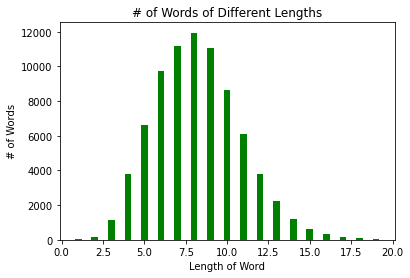

In [15]:
# calculate # of words of different lengths
dict = {}
for index in range(len(dataset.data)):
    p, g = dataset.data.iloc[index]
    if len(g) in dict:
        dict[len(g)] += 1
    else:
        dict[len(g)] = 1
Y = []
for ele in dict.keys():
    Y.append(dict[ele])
X = dict.keys()
fig = plt.figure()
plt.bar(X, Y, 0.4, color="green")
plt.xlabel("Length of Word")
plt.ylabel("# of Words")
plt.title("# of Words of Different Lengths")
plt.show()


This graph shows the distribution of lengths of words in the dataset. It looks like a normal with a slight leftward skew. The median word length is around 8, which happens to be the sequence length that vanilla seq2seq (e.g. Cho et al) implementations experience signifigant performance degrading. We will use a more complex architecture to hopefully deal with this, and we should expect best performance on words of length 8 since our data is concentrated there.

Now lets graph letter densities:

In [ ]:
# calculate the distribution of letters (graphemes)
dict = {}
for index in range(len(dataset.data)):
    p, g = dataset.data.iloc[index]
    lowString = g.lower()
    for char in lowString:
        if char in dict:
            dict[char] += 1
        else:
            dict[char] = 1
Y = []
for ele in dict.keys():
    Y.append(dict[ele]/len(dataset.data))

X = dict.keys()
fig = plt.figure()
plt.bar(sorted(X), Y, 0.4, color="green")
plt.xlabel("letter")
plt.ylabel("Average Number of Cccurrences in a Word")
plt.title("")
plt.show()

This chart shows the average amount of each letter in words in the dataset. No letter occurs more than once on average, but "g" is quite close. We would not expect any letters to occur more than once on average considering that the average word length is 8, but there are 26 grapheme characters. The surplus of "g"s is surprising and the unequal distribution of letters may lead to the model overpredicting "g"s. "h" occurs frequently, but "f" does not, so perhaps we will see strange spellings of the "f" sound, such as the well known example of "fish" being spelled as "ghoti" ("gh" produces the f sound as in laugh, "o" produces the "ih" sound as in women, and "ti" produces the shh sound as in potion). 🙂

# Architecture
We tested many varieties of RNNs for this project. We tried the following combinations:

Single layer GRU encoder+decoder

Double/Triple stacked GRU encoder+decoder

Single layer LSTM encoder+decoder

We also varied hidden sizes, testing 512 or 1024

We settled on the following architecture (hidden size 512):

Double bidirectional stacked GRU encoder -> linear layer which accepts the last forward/backward hidden layers and converts them to a vector the size of a single hidden layer -> unstacked unidirectional GRU decoder with Bahdanau attention.

## Reasoning
Why did we choose these neural networks and combinations, and what were their results? <br>
We chose these neural network types because we needed RNN for our sequence inputs, and we needed these RNNs to have cell states to deal with the complex and potentially long input sequences. Accuracy for these models generally sat around 30% on the test set.


What was our strategy for increasing accuracy? <br>

Deeper models, stacking GRUs, testing LSTMs, introducing attention

What else could we do to increase the accuracy? <br>
State of the art work on G2P for English (the opposite of our task) uses transformers. This would be the next step for this problem.

In [16]:
# hidden layer size
layer_size = 512
# define model architecture
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.GRU(len(phonemes), layer_size, 2, batch_first=True, bidirectional=True, dropout=0.5)
        self.fc = nn.Sequential(
            # takes final forwards and backwards hidden states
            nn.Linear(2 * layer_size, layer_size),
            nn.Tanh()
        )

    def forward(self, x):
        # push vector through encoder
        out, hidden = self.encoder(x)
        # hidden is [4, 1, layer_size]
        # this is because of bidirectionality * double stacked
        # we want to grab the "highest" layers from the forwards and backwards directions
        # dim 1 because hidden[3] and hidden[4] are both [1, layer_size] and we
        # want a single batch that has 2*layer_size values
        hc = torch.cat((hidden[2], hidden[3]), dim=1)
        hidden_for_init = self.fc(hc)

        # return context vector
        return out, hidden_for_init

class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        # 2 from encoder state and 1 from decoder state (since not bidirectional)
        self.energy = nn.Sequential(
            nn.Linear(3*layer_size, layer_size),
            nn.Tanh()
        )
        # map energy vectors to single values
        self.attention = nn.Linear(layer_size, 1, bias=False)

    def forward(self, encoder_hiddens, decoder_hidden):
        # encoder_hiddens is [1, L, layer_size*2] bc bidirectional
        # decoder_hidden is [1, layer_size]
        # 1 bc using batch first
        num_encoder_hiddens = encoder_hiddens.shape[1]

        # make it [1,1,layer_size]
        decoder_hidden = torch.unsqueeze(decoder_hidden, 0)

        # repeat along second dim to get [4, 1, layer_size]

        decoder_hiddens = decoder_hidden.squeeze(0).repeat(1, num_encoder_hiddens, 1)

        inputs = torch.cat((encoder_hiddens, decoder_hiddens), 2)

        energy = self.energy(inputs)

        attention = self.attention(energy)

        # want a distribution of attention that sums to 1
        return F.softmax(attention, dim=2)

class Decoder(nn.Module):
    def __init__(self, attention):
        super().__init__()
        self.attention = attention
        # decoder GRU takes in previous output word, attention vector, current hidden state
        self.decoder = nn.GRU(len(graphemes) + 2*layer_size, layer_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(layer_size*3 + len(graphemes), len(graphemes))
        )

    def forward(self, input, hidden_layer, encoder_hiddens):
        """
        Since this function gets called once at a time rather than taking in
        a sequence of vectors, we need to pass it the last output. This will be just
        a vector of numbers that can be converted to the embedding representing that last output
        """
        # [1,1,layer_size]
        attention_vals = self.attention(encoder_hiddens, hidden_layer)
        attention_vals = attention_vals.permute(0, 2, 1)

        # encoder_hiddens [1,L,layer_size]
        # this just multiplies each attention value against the appropriate vector
        # and sums the weighted vectors
        # will be [1, 1, layer_size]
        attended = torch.bmm(attention_vals, encoder_hiddens)
        input = torch.cat((attended, input), dim=2)
        out, hidden = self.decoder(input, hidden_layer)
        # out[1] to get top hidden layer
        input_for_fc = torch.cat((input, out), dim = 2)

        return self.fc(input_for_fc), hidden

class seq2seq(nn.Module):
    """The seq2seq model itself"""
    def __init__(self, device):
        super().__init__()
        # instantiate encoder and decoder with attention
        self.encoder = Encoder()
        self.decoder = Decoder(Attention())
        self.device = device

    def forward(self, in_seq, out_seq, tf_ratio=0.5):
        """
        :param tf_ratio: is the teacher forcing ratio. It decides how frequently
        the model receives its own previously predicted token as opposed to the
        known correct token.
        """
        out_len = out_seq.shape[1]
        # storing the outputs of the sequence
        outputs = torch.zeros(out_len, 1, len(graphemes)).to(self.device)

        out_for_at, hidden = self.encoder(in_seq)
        hidden = hidden.unsqueeze(0)
        out_seq = out_seq.squeeze(0)

        # perform an embarassing amount of data conversions
        input = out_seq[0].unsqueeze(0).unsqueeze(0).float().to(device)

        # for each token in known out sequence (except the first)
        for i in range(1, out_len):
            out, hidden = self.decoder(input, hidden, out_for_at)
            outputs[i] = out

            if random.random() > tf_ratio:
                # teacher forcing (make next input what the current output token should be)
                input = out_seq[i].unsqueeze(0).unsqueeze(0).float().to(device)
            else:
                # use previously output token
                x = input.argmax(1)[0]
                input = torch.zeros(1, 1, len(graphemes)).to(self.device)
                input[0][0][x] = 1

        return outputs

    def pred_new(self, in_seq):
        """Method to predict the output sequence for a previously unseen
        input sequence. The main difference between this function and forward
        is that this function only stops decoding when the model produces and
        end token
        """
        encoder_out_for_at, hidden = self.encoder(in_seq)
        hidden = hidden.unsqueeze(0)
        input = torch.zeros(1, 1, len(graphemes)).to(self.device)
        outs = []
        while True:
            out, hidden = self.decoder(input, hidden, encoder_out_for_at)
            outs.append(out)
            # in case not hitting end token
            if len(outs) > 50:
                break
            x = input.argmax(1)[0]
            input = torch.zeros(1, 1, len(graphemes)).to(self.device)
            input[0][0][x] = 1
            if one_hot_to_nemes(out) == ['1']:
                break
        return outs

## Getting ready to train

Now that we have a beautiful architecture, we need to instantiate it as well as a loss function and an optimizer. We use cross entropy loss since the model outputs a "class" (one of a number of possible tokens) at each decoding step. Well also use Adam, since more vanilla optimizers (e.g. SGD or SGD+momentum) will tend not to converge on a network this complex.

We perform a ~90%-10% train test split and define a function for testing the 0-1 accuracy of the model. 0-1 accuracy counts only the words which the model gets exactly correct.

Note that hyperparameters were tuned by hand.

In [17]:
# initialize optimizer/loss func/hyperparams
EPOCHS = 15
model = seq2seq(device).to(device)
# what a beautiful architecture
print("Model architecture ", model)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()
# train on 70000 words
train, test = random_split(dataset, [70000, len(dataset)-70000])
dataloader = DataLoader(dataset=train, batch_size=1)
print("train size ", len(train))
print("test size ", len(test))

def get_0_1_accuracy(test_set, model):
    """method to compute 1-WER accuracy AKA what % of test_set does model get
    exactly correct."""
    correct = 0
    dataloader = DataLoader(dataset=test_set, batch_size=1)
    for (in_seq, out_seq) in dataloader:
        prediction = model.pred_new(in_seq[0])
        true = "".join(one_hot_to_nemes(out_seq[0][0], "graphemes"))[1:-1]
        print(true)
        pred = "".join(one_hot_to_nemes(prediction, "graphemes"))[0:-1]
        print(pred)

        if true == pred:
            correct+= 1
    if correct == 0:
        return correct
    return correct/len(test_set)


Model architecture  seq2seq(
  (encoder): Encoder(
    (encoder): GRU(51, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): Tanh()
    )
  )
  (decoder): Decoder(
    (attention): Attention(
      (energy): Sequential(
        (0): Linear(in_features=1536, out_features=512, bias=True)
        (1): Tanh()
      )
      (attention): Linear(in_features=512, out_features=1, bias=False)
    )
    (decoder): GRU(1052, 512, batch_first=True)
    (fc): Sequential(
      (0): Linear(in_features=1564, out_features=28, bias=True)
    )
  )
)
train size  70000
test size  8845


In [18]:
print("# of model parameters: ", sum(p.numel() for p in model.parameters()))

# of model parameters:  10221868


Wow 10 million params! This model has more trainable parameters than tonnes of potatoes France produced in 2016! (absolutely no semantic relation). This might take a while to train, so make sure to use a NVIDIA GeForce RTX 3090 Ti 🙂.

## Training

Our training loop is quite simple. We use a batch size of 1, so as not to deal with padding/packing. We record a couple metrics like loss and current accuracy on the test set as the model progresses. This part will likely take a while to compute.

In [ ]:
writer = SummaryWriter("tensorboard_data")
# get a mini testing batch to check model accuracy on the test set
# throughout training
# NOTE: this is not a validation set
mini_test, _ = random_split(test, [20, len(test)-20])

# begin training loop
for epoch in range(EPOCHS):
    tot_loss = 0
    for (in_seq, out_seq) in dataloader:
        # batch size of 1
        in_seq = in_seq.squeeze(0)
        out_seq = out_seq.squeeze(0)
        # perform inference
        model_output = model(in_seq, out_seq)
        # dont compute loss using first token of in/out sequence
        model_output = model_output[1:]
        model_output = model_output.squeeze(1)
        out_seq = out_seq.squeeze(0)[1:]
        # compute loss
        loss = loss_func(model_output, out_seq.argmax(1).to(device))
        # record loss
        tot_loss+=loss.detach().item()
        # accumulate gradients
        loss.backward()
        # step and clear grads
        optimizer.step()
        optimizer.zero_grad()

    tot_loss/=len(train)
    # record current accuracy on test set and average loss
    writer.add_scalar("tensorboard_data/acc", get_0_1_accuracy(mini_test, model), epoch)
    writer.add_scalar("tensorboard_data/loss", tot_loss, epoch)
torch.save(model, "THEMODEL")

In [44]:
# load model onto cpu
model = torch.load("THEMODEL", map_location=torch.device('cpu')).to(torch.device('cpu'))
model.device = "cpu"
# turn dropout off
model.eval()

with torch.no_grad():
    print("Test accuracy: " + str(get_0_1_accuracy(test, model)))

plasma
plasma
obligatory
obligaaory
sciosophy
scyosopyy
inning
inning
ecchymosis
echmocisis
tailspin
tailspin
eudiometry
eudiometry
acetanilide
acetanllide
interlineate
interlinaate
dizygotic
dizigotic
heptad
heptad
gadhelic
gadhelic
wellaway
wellawayy
jesu
jeauu
boatsman
boaesman
blazon
blazonn
particularize
particularize
pure
pure
lusatian
lusatian
canonicate
canonicate
mendelevium
mendelvviu
hydrobomb
hydrabom
spoonful
spoonful
hexyl
hexicl
linguistics
linguistics
solution
soluuian
ringneck
ringneck
geometrize
geometrize
whang
whng
chayote
chiote
gunplay
gunplay
materially
materially
stripe
stripe
decathlon
dicathlon
intercessory
intercessory
miniate
miniaate
sarcode
sarcodd
tableau
tablo
weltanschauung
weltannnnkuuug
antilogism
antilogism
quintessential
quincesential
businesswoman
businnsssooann
scarph
scarf
stockinged
stocking
incorporeity
incorporeity
fascination
fascination
roadway
roaeway
bullshit
bullshit
uninteresting
unintrinsting
disintegration
disintegration
picnic
pyknicc

Well that accuracy is... disappointing. It might be better than the average human (when faced with 10s of thousands of rare words), but thats still a lot of error.

What is the reason for this?

Even though the attention module should, in theory, allow the model to be much more performant, the English language is rife with inconsistent spelling and pronunciation rules. Additionally, some words (e.g. their, theyre, there) are pronounced the same, so the model does not have enough information to distinguish between them. One more confounding factor is that the phonemes we are using are from the International Phonetic Alphabet, so are not as specific to the English language as the Carnegie Melon pronunciation dictionary ARPAbet (an English prononciation specification). Thus, the model needs to learn more complex rules, especially considering that there are more distinct phonemes in IPA than in ARPAbet. However, our use of IPA in theory allows better spelling on non-English words.

What can we do about this poor performance? We can see a couple cells up that the model is generally off by just a few grapheme characters. Hopefully you are already thinking along the lines of spellcheck 🙂.

![alt text](secret_ingredient.jpg)

Here is a function similar to the 0_1_accuracy function above, but this one just returns the lists of words.

In [26]:
def get_true_pred_lists(test_set, model):
    """Returns a list of correct outputs and a corresponding list of model predictions"""
    trues = []
    preds = []
    dataloader = DataLoader(dataset=test_set, batch_size=1)
    for (in_seq, out_seq) in dataloader:
        prediction = model.pred_new(in_seq[0])
        true = "".join(one_hot_to_nemes(out_seq[0][0], "graphemes"))[1:-1]
        trues.append(true)
        pred = "".join(one_hot_to_nemes(prediction, "graphemes"))[0:-1]
        preds.append(pred)

    return trues, preds

Lets import a spellcheck library and give it our known grapheme spellings

In [32]:
import codecs
from spellchecker import SpellChecker

dict_filename = "words_beta.txt"  # `Name of the file containing many words - error
err_filename = "404s.txt"  # List of all of the known error words

dict_file = open(dict_filename).read()
dict_list = dict_file.split("\n")

a_dict = set(codecs.open("words_alpha.txt", "r", "utf-8-sig").read().replace("\r", "").split("\n"))

err = set(codecs.open(err_filename, "r", "utf-8-sig").read().replace("\r", "").split("\n"))

new_dict_set = list(a_dict - err)  # Subtract the set of errors from the beta dictionary

spellcheck = SpellChecker().correction

# Only spell check incorrect strings
def spellcheck_1(string):
    spellchecked = string

    # Check if the presented string is in the list of known words
    if not string in a_dict:
        # Attempt to autocorrect the word
        spellchecked = spellcheck("".join(string))
        # print("new_word: " + spellchecked)
    return spellchecked

trues, preds = get_true_pred_lists(test, model)

def spellcheck_all(str_list):
    new_list = [None] * len(str_list)
    str_list = list(str_list)

    for i in range(len(str_list)):
        new_list[i] = spellcheck_1(str_list[i])

    # print("original list: " + str(new_list))
    return new_list

def get_0_1_accuracy_with_spellcheck(trues, preds):
    """compute 0 1 accuracy, but using spell check"""
    correct = 0
    for (true, pred) in zip(trues, preds):
        if spellcheck_1(pred) == true:
            correct+=1
    return correct / len(trues)

In [41]:
# print(get_0_1_accuracy_with_spellcheck(preds, trues))
spell_checked_words = spellcheck_all(preds)

KeyboardInterrupt: 

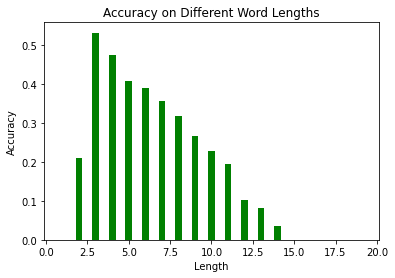

In [40]:
import matplotlib.pyplot as plt

def gen_accuracy_plot (real, model, title):
    accuracy = {}
    dict = {}

    for i in range(len(real)): # (iterate through all elements in real)
        if real[i] == model[i]: # If the elements match
           if len(real[i]) in accuracy: # if the length of the element is in dictionary "accuracy"
               accuracy[len(real[i])] += 1 # add 1 to the length of the element
           else:
               accuracy[len(real[i])] = 1 # otherwise add the length as a new element starting from 1
        else: # if the real element does not match
            if len(real[i]) not in accuracy: # If the length of the real element is not in accuracy
                accuracy[len(real[i])] = 0 # add the length as a new element starting from 0

        if len(real[i]) in dict:  #if the length is already in dictionary, "dict"
            dict[len(real[i])] += 1 # add one 
        else:
            dict[len(real[i])] = 1 # otherwise add a new element for that length beginning from one
    X = dict.keys() # get all of the total elements with each length
    Y = [] 
    for i in X: # add each total correct element as a float to the list Y and divide by the total number of elements for that length
        Y.append(1.0*accuracy[i]/dict[i]) 
    plt.bar(X, Y, 0.4, color="green")
    plt.xlabel("Length")
    plt.ylabel("Accuracy")
    plt.title(title)

gen_accuracy_plot(trues, preds, "Accuracy on Different Word Lengths")

# Resources
If the reader would like more resources related to this topic:

For learning the basics of RNNs, LSTMs, GRUs, attention (including Bahdanau), and seq2seq architectures, these resources are good:

https://www.deeplearningbook.org/contents/rnn.html

https://d2l.ai/chapter_recurrent-modern/seq2seq.html

https://d2l.ai/chapter_attention-mechanisms/bahdanau-attention.html

For more comprehensive tutorials that walk through the full deep learning process (including varied seq2seq architectures such as transformer), this is a good resource:

https://github.com/bentrevett/pytorch-seq2seq

These papers discuss grapheme->phoneme conversion with deep learning. This is an easier problem, but still requires complex models for high success rates:

https://arxiv.org/abs/2004.06338

https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43264.pdf

Addtionally, here is a link to Cho et al's foundational seq2seq model paper:

https://arxiv.org/abs/1406.1078